## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 9.51 and accuracy of 0.016
Iteration 100: with minibatch training loss = 1.08 and accuracy of 0.25
Iteration 200: with minibatch training loss = 0.833 and accuracy of 0.3
Iteration 300: with minibatch training loss = 0.605 and accuracy of 0.38
Iteration 400: with minibatch training loss = 0.59 and accuracy of 0.39
Iteration 500: with minibatch training loss = 0.544 and accuracy of 0.28
Iteration 600: with minibatch training loss = 0.537 and accuracy of 0.3
Iteration 700: with minibatch training loss = 0.386 and accuracy of 0.44
Epoch 1, Overall loss = 0.765 and accuracy of 0.314


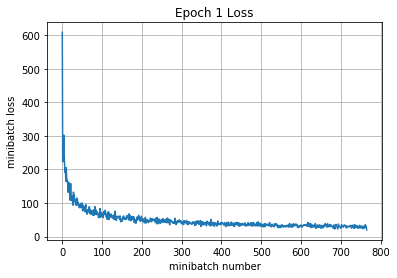

Validation
Epoch 1, Overall loss = 0.472 and accuracy of 0.356


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    #set up variables
    Wconv1=tf.get_variable('Wconv1',shape=[7,7,3,32])
    bconv1=tf.get_variable('bconv1',shape=[32])
    #gamma=tf.get_varialbe('gamma',shape=[])
    Wfc1=tf.get_variable('Wfc1',shape=[5408,1024])
    bfc1=tf.get_variable('bfc1',shape=[1024])
    Wfc2=tf.get_variable('Wfc2',shape=[1024,10])
    bfc2=tf.get_variable('bfc2',shape=[10])
    
    a1=tf.nn.conv2d(X,Wconv1,strides=[1,1,1,1],padding='VALID')+bconv1
    h1=tf.nn.relu(a1)
    h2=tf.layers.batch_normalization(h1,training=is_training)
    h3=tf.nn.max_pool(h2,ksize=(1,2,2,1),strides=[1,2,2,1],padding='SAME')
    h4=tf.matmul(tf.reshape(h3,(-1,5408)),Wfc1)+bfc1
    h5=tf.nn.relu(h4)
    y_out=tf.matmul(h5,Wfc2)+bfc2
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

2.81 ms ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

2.93 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None

total_loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=y_out)
mean_loss=tf.reduce_mean(total_loss)
optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-3)


In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.33 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.53 and accuracy of 0.31
Iteration 200: with minibatch training loss = 1.58 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.6 and accuracy of 0.44
Iteration 400: with minibatch training loss = 1.41 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.46 and accuracy of 0.48
Iteration 600: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.43 and accuracy of 0.45
Epoch 1, Overall loss = 1.69 and accuracy of 0.446


(1.6930098575475265, 0.4460612244897959)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.4 and accuracy of 0.533


(1.402388747215271, 0.533)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [12]:
# Feel free to play with this cell
DROPOUT_RATE = 0.5
init = tf.contrib.layers.xavier_initializer()
def res_block(input_layer, i):
    with tf.variable_scope("res_block"+str(i)):
        res_conv1 = tf.layers.conv2d(input_layer, 96, kernel_size=3, strides=1, kernel_initializer=init, padding='SAME')
        res_bn1 = tf.layers.batch_normalization(res_conv1,training=is_training)
        res_conv2 = tf.layers.conv2d(tf.nn.relu(res_bn1), 96, kernel_size=3, strides=1, kernel_initializer=init, padding='SAME')
        res_bn2 = tf.layers.batch_normalization(res_conv2,training=is_training)
        res_out = tf.nn.relu(input_layer +  res_bn2)
    return res_out
        
def my_model(X,y,is_training):
    conv1 = tf.layers.conv2d(X, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn1 = tf.layers.batch_normalization(conv1,training=is_training)
    conv2 = tf.layers.conv2d(bn1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn2 = tf.layers.batch_normalization(conv2,training=is_training)
    pool1 = tf.layers.max_pooling2d(bn2, pool_size=2, strides=2)
    dp1 = tf.layers.dropout(pool1, rate=DROPOUT_RATE, training=is_training)
    
    conv3 = tf.layers.conv2d(dp1, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn3 = tf.layers.batch_normalization(conv3,training=is_training)
    conv4 = tf.layers.conv2d(bn3, 96, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_initializer=init)
    bn4 = tf.layers.batch_normalization(conv4,training=is_training)
    pool2 = tf.layers.max_pooling2d(bn4, pool_size=2, strides=2)
    dp2 = tf.layers.dropout(pool2, rate=DROPOUT_RATE, training=is_training)
    
    res_input = dp2
    for i in range(5):
        res_out = res_block(res_input, i)
    
    flatten = tf.reshape(res_out, [-1, 5*5*96])
    fc1 = tf.layers.dense(flatten, 384, activation=tf.nn.relu)
    fc_bn1 = tf.layers.batch_normalization(fc1,center=False,scale=False,training=is_training)
    fc_dp1 = tf.layers.dropout(fc_bn1, rate=DROPOUT_RATE, training=is_training)
    fc2 = tf.layers.dense(fc_dp1, 192, activation=tf.nn.relu)
    fc_bn2 = tf.layers.batch_normalization(fc2,center=False,scale=False,training=is_training)
    fc_dp2 = tf.layers.dropout(fc_bn2, rate=DROPOUT_RATE, training=is_training)
    fc3 = tf.layers.dense(fc_dp2, 10, activation=tf.nn.relu)
    fc_bn3 = tf.layers.batch_normalization(fc3,center=False,scale=False,training=is_training)
    return fc3
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
global_acc = tf.Variable(0, trainable=False, dtype=tf.float32)
learning_rate = tf.train.piecewise_constant(global_acc, [0.6, 0.7, 0.8, 0.9], [1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 3.01 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.98 and accuracy of 0.11
Iteration 200: with minibatch training loss = 2.52 and accuracy of 0.2
Iteration 300: with minibatch training loss = 2.59 and accuracy of 0.14
Iteration 400: with minibatch training loss = 2.62 and accuracy of 0.16
Iteration 500: with minibatch training loss = 2.39 and accuracy of 0.12
Iteration 600: with minibatch training loss = 2.44 and accuracy of 0.17
Iteration 700: with minibatch training loss = 2.39 and accuracy of 0.28
Epoch 1, Overall loss = 2.53 and accuracy of 0.202


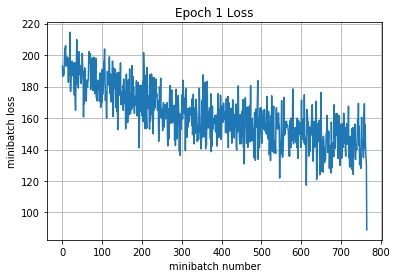

Iteration 800: with minibatch training loss = 2.33 and accuracy of 0.27
Iteration 900: with minibatch training loss = 2.02 and accuracy of 0.34
Iteration 1000: with minibatch training loss = 1.84 and accuracy of 0.39
Iteration 1100: with minibatch training loss = 2.08 and accuracy of 0.3
Iteration 1200: with minibatch training loss = 2.12 and accuracy of 0.31
Iteration 1300: with minibatch training loss = 1.9 and accuracy of 0.34
Iteration 1400: with minibatch training loss = 2.32 and accuracy of 0.2
Iteration 1500: with minibatch training loss = 2.05 and accuracy of 0.33
Epoch 2, Overall loss = 2.08 and accuracy of 0.303


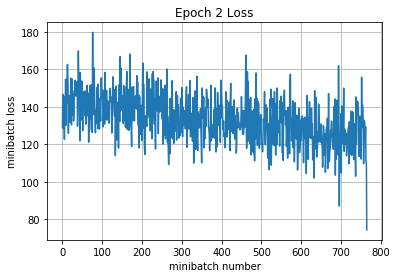

Iteration 1600: with minibatch training loss = 1.79 and accuracy of 0.34
Iteration 1700: with minibatch training loss = 1.87 and accuracy of 0.31
Iteration 1800: with minibatch training loss = 1.84 and accuracy of 0.33
Iteration 1900: with minibatch training loss = 1.63 and accuracy of 0.47
Iteration 2000: with minibatch training loss = 1.82 and accuracy of 0.36
Iteration 2100: with minibatch training loss = 1.67 and accuracy of 0.38
Iteration 2200: with minibatch training loss = 1.7 and accuracy of 0.44
Epoch 3, Overall loss = 1.84 and accuracy of 0.365


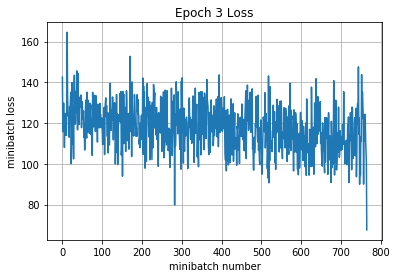

Iteration 2300: with minibatch training loss = 1.74 and accuracy of 0.42
Iteration 2400: with minibatch training loss = 1.56 and accuracy of 0.53
Iteration 2500: with minibatch training loss = 1.95 and accuracy of 0.42
Iteration 2600: with minibatch training loss = 1.83 and accuracy of 0.42
Iteration 2700: with minibatch training loss = 1.62 and accuracy of 0.42
Iteration 2800: with minibatch training loss = 1.39 and accuracy of 0.5
Iteration 2900: with minibatch training loss = 1.95 and accuracy of 0.45
Iteration 3000: with minibatch training loss = 1.54 and accuracy of 0.42
Epoch 4, Overall loss = 1.68 and accuracy of 0.416


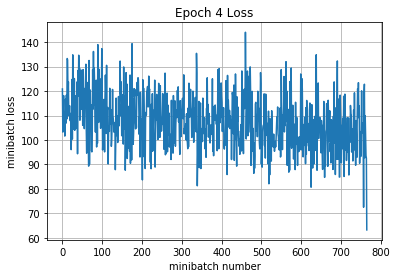

Iteration 3100: with minibatch training loss = 1.59 and accuracy of 0.42
Iteration 3200: with minibatch training loss = 1.4 and accuracy of 0.53
Iteration 3300: with minibatch training loss = 1.59 and accuracy of 0.47
Iteration 3400: with minibatch training loss = 1.46 and accuracy of 0.44
Iteration 3500: with minibatch training loss = 1.42 and accuracy of 0.53
Iteration 3600: with minibatch training loss = 1.36 and accuracy of 0.5
Iteration 3700: with minibatch training loss = 1.77 and accuracy of 0.36
Iteration 3800: with minibatch training loss = 1.35 and accuracy of 0.56
Epoch 5, Overall loss = 1.55 and accuracy of 0.461


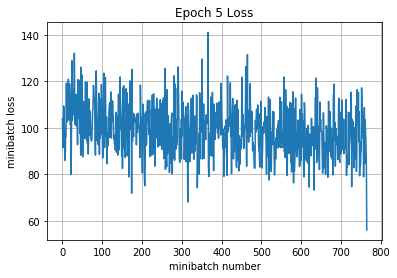

Iteration 3900: with minibatch training loss = 1.73 and accuracy of 0.41
Iteration 4000: with minibatch training loss = 1.7 and accuracy of 0.41
Iteration 4100: with minibatch training loss = 1.4 and accuracy of 0.48
Iteration 4200: with minibatch training loss = 1.55 and accuracy of 0.45
Iteration 4300: with minibatch training loss = 1.48 and accuracy of 0.5
Iteration 4400: with minibatch training loss = 1.35 and accuracy of 0.53
Iteration 4500: with minibatch training loss = 1.3 and accuracy of 0.52
Epoch 6, Overall loss = 1.44 and accuracy of 0.499


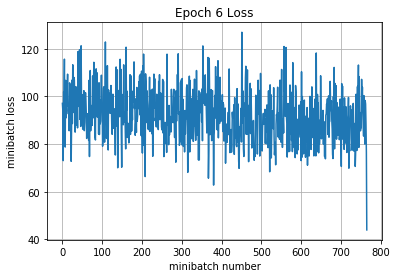

Iteration 4600: with minibatch training loss = 1.57 and accuracy of 0.42
Iteration 4700: with minibatch training loss = 1.48 and accuracy of 0.53
Iteration 4800: with minibatch training loss = 1.53 and accuracy of 0.5
Iteration 4900: with minibatch training loss = 1.17 and accuracy of 0.64
Iteration 5000: with minibatch training loss = 1.31 and accuracy of 0.61
Iteration 5100: with minibatch training loss = 1.42 and accuracy of 0.5
Iteration 5200: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 5300: with minibatch training loss = 1.16 and accuracy of 0.59
Epoch 7, Overall loss = 1.34 and accuracy of 0.535


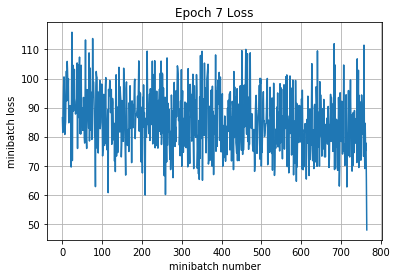

Iteration 5400: with minibatch training loss = 0.913 and accuracy of 0.72
Iteration 5500: with minibatch training loss = 1.32 and accuracy of 0.58
Iteration 5600: with minibatch training loss = 1.25 and accuracy of 0.5
Iteration 5700: with minibatch training loss = 1.36 and accuracy of 0.56
Iteration 5800: with minibatch training loss = 1.13 and accuracy of 0.59
Iteration 5900: with minibatch training loss = 1.21 and accuracy of 0.56
Iteration 6000: with minibatch training loss = 1.51 and accuracy of 0.55
Iteration 6100: with minibatch training loss = 1.27 and accuracy of 0.55
Epoch 8, Overall loss = 1.26 and accuracy of 0.56


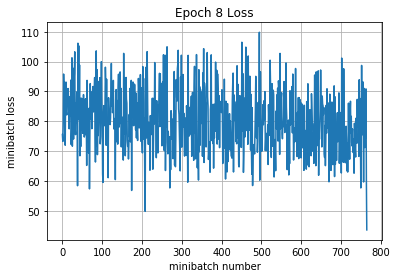

Iteration 6200: with minibatch training loss = 1.28 and accuracy of 0.52
Iteration 6300: with minibatch training loss = 1.3 and accuracy of 0.53
Iteration 6400: with minibatch training loss = 0.904 and accuracy of 0.67
Iteration 6500: with minibatch training loss = 1.14 and accuracy of 0.66
Iteration 6600: with minibatch training loss = 1.48 and accuracy of 0.48
Iteration 6700: with minibatch training loss = 1.29 and accuracy of 0.61
Iteration 6800: with minibatch training loss = 1.09 and accuracy of 0.64
Epoch 9, Overall loss = 1.18 and accuracy of 0.59


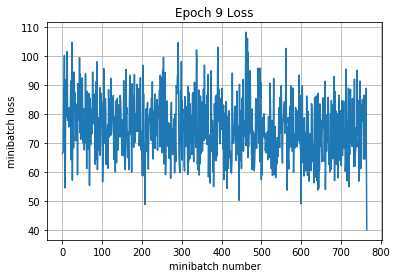

Iteration 6900: with minibatch training loss = 1.15 and accuracy of 0.59
Iteration 7000: with minibatch training loss = 0.9 and accuracy of 0.72
Iteration 7100: with minibatch training loss = 0.898 and accuracy of 0.67
Iteration 7200: with minibatch training loss = 1.08 and accuracy of 0.59
Iteration 7300: with minibatch training loss = 0.876 and accuracy of 0.72
Iteration 7400: with minibatch training loss = 1.15 and accuracy of 0.58
Iteration 7500: with minibatch training loss = 1.17 and accuracy of 0.62
Iteration 7600: with minibatch training loss = 1 and accuracy of 0.67
Epoch 10, Overall loss = 1.11 and accuracy of 0.613


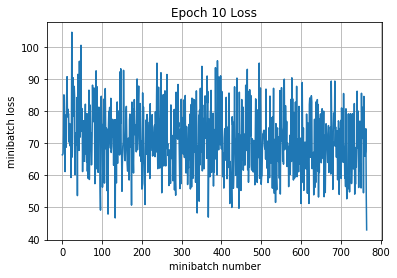

Iteration 7700: with minibatch training loss = 1.05 and accuracy of 0.59
Iteration 7800: with minibatch training loss = 1.04 and accuracy of 0.69
Iteration 7900: with minibatch training loss = 1.11 and accuracy of 0.59
Iteration 8000: with minibatch training loss = 1.07 and accuracy of 0.69
Iteration 8100: with minibatch training loss = 0.824 and accuracy of 0.72
Iteration 8200: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 8300: with minibatch training loss = 0.903 and accuracy of 0.64
Iteration 8400: with minibatch training loss = 0.831 and accuracy of 0.72
Epoch 11, Overall loss = 1.05 and accuracy of 0.633


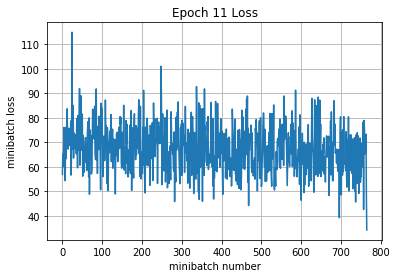

Iteration 8500: with minibatch training loss = 0.784 and accuracy of 0.73
Iteration 8600: with minibatch training loss = 0.754 and accuracy of 0.72
Iteration 8700: with minibatch training loss = 1.16 and accuracy of 0.62
Iteration 8800: with minibatch training loss = 1.33 and accuracy of 0.58
Iteration 8900: with minibatch training loss = 0.922 and accuracy of 0.62
Iteration 9000: with minibatch training loss = 0.943 and accuracy of 0.69
Iteration 9100: with minibatch training loss = 1.23 and accuracy of 0.56
Epoch 12, Overall loss = 1 and accuracy of 0.652


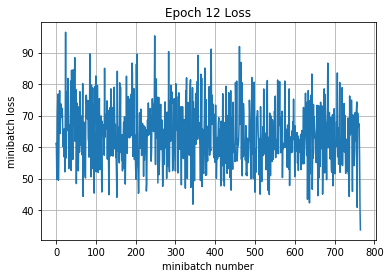

Iteration 9200: with minibatch training loss = 1.14 and accuracy of 0.66
Iteration 9300: with minibatch training loss = 1.18 and accuracy of 0.62
Iteration 9400: with minibatch training loss = 0.71 and accuracy of 0.81
Iteration 9500: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 9600: with minibatch training loss = 0.948 and accuracy of 0.64
Iteration 9700: with minibatch training loss = 0.947 and accuracy of 0.67
Iteration 9800: with minibatch training loss = 0.872 and accuracy of 0.69
Iteration 9900: with minibatch training loss = 0.824 and accuracy of 0.77
Epoch 13, Overall loss = 0.951 and accuracy of 0.669


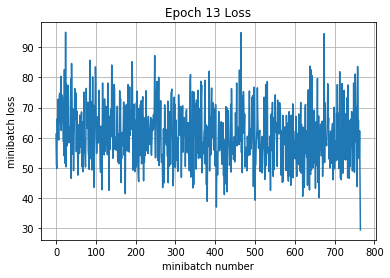

Iteration 10000: with minibatch training loss = 0.894 and accuracy of 0.69
Iteration 10100: with minibatch training loss = 1.11 and accuracy of 0.53
Iteration 10200: with minibatch training loss = 1.18 and accuracy of 0.58
Iteration 10300: with minibatch training loss = 0.818 and accuracy of 0.7
Iteration 10400: with minibatch training loss = 1.12 and accuracy of 0.56
Iteration 10500: with minibatch training loss = 0.96 and accuracy of 0.62
Iteration 10600: with minibatch training loss = 0.764 and accuracy of 0.77
Iteration 10700: with minibatch training loss = 0.967 and accuracy of 0.62
Epoch 14, Overall loss = 0.913 and accuracy of 0.686


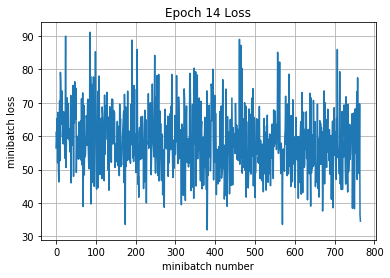

Iteration 10800: with minibatch training loss = 1.18 and accuracy of 0.59
Iteration 10900: with minibatch training loss = 0.835 and accuracy of 0.69
Iteration 11000: with minibatch training loss = 0.894 and accuracy of 0.66
Iteration 11100: with minibatch training loss = 0.844 and accuracy of 0.69
Iteration 11200: with minibatch training loss = 0.8 and accuracy of 0.72
Iteration 11300: with minibatch training loss = 0.777 and accuracy of 0.77
Iteration 11400: with minibatch training loss = 0.966 and accuracy of 0.62
Epoch 15, Overall loss = 0.872 and accuracy of 0.698


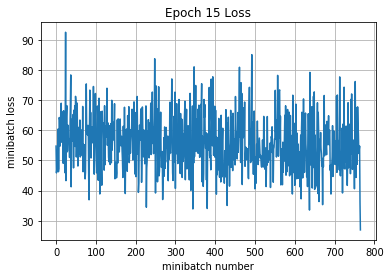

Iteration 11500: with minibatch training loss = 0.8 and accuracy of 0.77
Iteration 11600: with minibatch training loss = 0.771 and accuracy of 0.73
Iteration 11700: with minibatch training loss = 0.944 and accuracy of 0.7
Iteration 11800: with minibatch training loss = 0.731 and accuracy of 0.73
Iteration 11900: with minibatch training loss = 0.858 and accuracy of 0.61
Iteration 12000: with minibatch training loss = 0.684 and accuracy of 0.7
Iteration 12100: with minibatch training loss = 0.823 and accuracy of 0.72
Iteration 12200: with minibatch training loss = 0.709 and accuracy of 0.72
Epoch 16, Overall loss = 0.843 and accuracy of 0.709


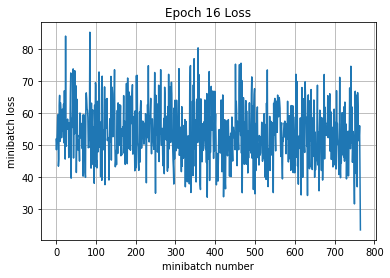

Iteration 12300: with minibatch training loss = 0.571 and accuracy of 0.81
Iteration 12400: with minibatch training loss = 1.07 and accuracy of 0.67
Iteration 12500: with minibatch training loss = 0.932 and accuracy of 0.69
Iteration 12600: with minibatch training loss = 0.612 and accuracy of 0.75
Iteration 12700: with minibatch training loss = 0.528 and accuracy of 0.88
Iteration 12800: with minibatch training loss = 0.83 and accuracy of 0.75
Iteration 12900: with minibatch training loss = 0.568 and accuracy of 0.81
Iteration 13000: with minibatch training loss = 1.02 and accuracy of 0.67
Epoch 17, Overall loss = 0.815 and accuracy of 0.719


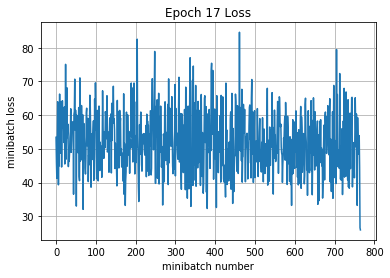

Iteration 13100: with minibatch training loss = 0.827 and accuracy of 0.75
Iteration 13200: with minibatch training loss = 0.691 and accuracy of 0.77
Iteration 13300: with minibatch training loss = 0.674 and accuracy of 0.75
Iteration 13400: with minibatch training loss = 0.526 and accuracy of 0.8
Iteration 13500: with minibatch training loss = 0.708 and accuracy of 0.75
Iteration 13600: with minibatch training loss = 0.806 and accuracy of 0.72
Iteration 13700: with minibatch training loss = 0.863 and accuracy of 0.7
Epoch 18, Overall loss = 0.788 and accuracy of 0.731


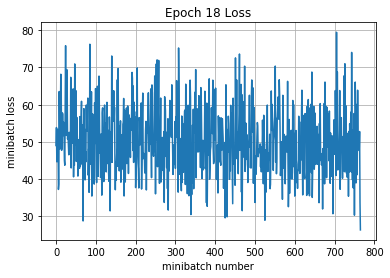

Iteration 13800: with minibatch training loss = 0.895 and accuracy of 0.61
Iteration 13900: with minibatch training loss = 0.686 and accuracy of 0.72
Iteration 14000: with minibatch training loss = 0.725 and accuracy of 0.77
Iteration 14100: with minibatch training loss = 0.683 and accuracy of 0.7
Iteration 14200: with minibatch training loss = 0.864 and accuracy of 0.69
Iteration 14300: with minibatch training loss = 0.678 and accuracy of 0.78
Iteration 14400: with minibatch training loss = 0.736 and accuracy of 0.72
Iteration 14500: with minibatch training loss = 0.518 and accuracy of 0.81
Epoch 19, Overall loss = 0.756 and accuracy of 0.739


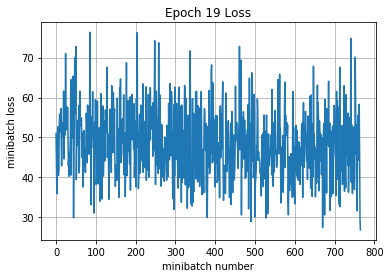

Iteration 14600: with minibatch training loss = 0.747 and accuracy of 0.7
Iteration 14700: with minibatch training loss = 0.724 and accuracy of 0.78
Iteration 14800: with minibatch training loss = 0.64 and accuracy of 0.77
Iteration 14900: with minibatch training loss = 0.581 and accuracy of 0.83
Iteration 15000: with minibatch training loss = 0.772 and accuracy of 0.7
Iteration 15100: with minibatch training loss = 0.627 and accuracy of 0.75
Iteration 15200: with minibatch training loss = 0.608 and accuracy of 0.75
Iteration 15300: with minibatch training loss = 0.699 and accuracy of 0.78
Epoch 20, Overall loss = 0.734 and accuracy of 0.746


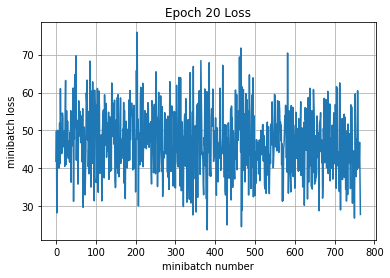

Iteration 15400: with minibatch training loss = 1.06 and accuracy of 0.67
Iteration 15500: with minibatch training loss = 0.836 and accuracy of 0.75
Iteration 15600: with minibatch training loss = 0.602 and accuracy of 0.78
Iteration 15700: with minibatch training loss = 0.39 and accuracy of 0.86
Iteration 15800: with minibatch training loss = 0.707 and accuracy of 0.72
Iteration 15900: with minibatch training loss = 0.752 and accuracy of 0.72
Iteration 16000: with minibatch training loss = 0.601 and accuracy of 0.8
Epoch 21, Overall loss = 0.711 and accuracy of 0.757


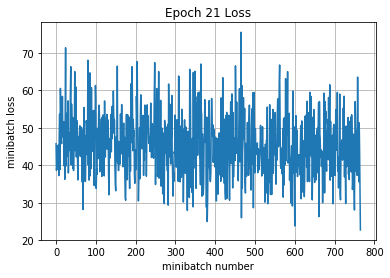

Iteration 16100: with minibatch training loss = 0.589 and accuracy of 0.78
Iteration 16200: with minibatch training loss = 0.655 and accuracy of 0.81
Iteration 16300: with minibatch training loss = 0.76 and accuracy of 0.72
Iteration 16400: with minibatch training loss = 0.637 and accuracy of 0.75
Iteration 16500: with minibatch training loss = 0.538 and accuracy of 0.8
Iteration 16600: with minibatch training loss = 0.763 and accuracy of 0.75
Iteration 16700: with minibatch training loss = 0.695 and accuracy of 0.83
Iteration 16800: with minibatch training loss = 0.469 and accuracy of 0.8
Epoch 22, Overall loss = 0.694 and accuracy of 0.762


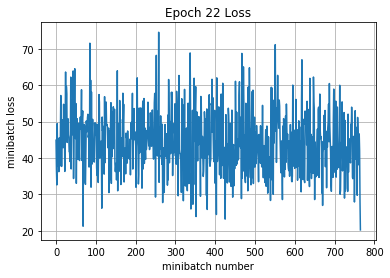

Iteration 16900: with minibatch training loss = 0.775 and accuracy of 0.77
Iteration 17000: with minibatch training loss = 0.55 and accuracy of 0.77
Iteration 17100: with minibatch training loss = 1.07 and accuracy of 0.61
Iteration 17200: with minibatch training loss = 0.725 and accuracy of 0.77
Iteration 17300: with minibatch training loss = 0.623 and accuracy of 0.73
Iteration 17400: with minibatch training loss = 0.497 and accuracy of 0.83
Iteration 17500: with minibatch training loss = 0.82 and accuracy of 0.75
Iteration 17600: with minibatch training loss = 0.769 and accuracy of 0.66
Epoch 23, Overall loss = 0.68 and accuracy of 0.769


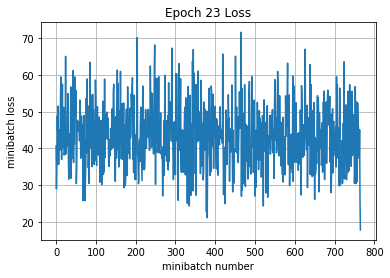

Iteration 17700: with minibatch training loss = 0.448 and accuracy of 0.88
Iteration 17800: with minibatch training loss = 0.695 and accuracy of 0.77
Iteration 17900: with minibatch training loss = 0.502 and accuracy of 0.75
Iteration 18000: with minibatch training loss = 0.61 and accuracy of 0.75
Iteration 18100: with minibatch training loss = 0.498 and accuracy of 0.84
Iteration 18200: with minibatch training loss = 0.837 and accuracy of 0.73
Iteration 18300: with minibatch training loss = 0.728 and accuracy of 0.75
Epoch 24, Overall loss = 0.663 and accuracy of 0.772


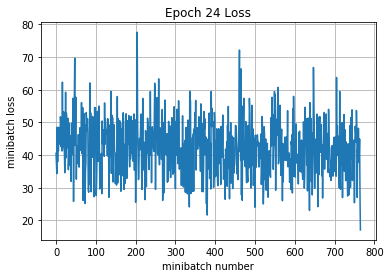

Iteration 18400: with minibatch training loss = 0.835 and accuracy of 0.67
Iteration 18500: with minibatch training loss = 0.699 and accuracy of 0.8
Iteration 18600: with minibatch training loss = 0.615 and accuracy of 0.77
Iteration 18700: with minibatch training loss = 0.754 and accuracy of 0.73
Iteration 18800: with minibatch training loss = 0.608 and accuracy of 0.77
Iteration 18900: with minibatch training loss = 0.491 and accuracy of 0.83
Iteration 19000: with minibatch training loss = 0.489 and accuracy of 0.81
Iteration 19100: with minibatch training loss = 0.601 and accuracy of 0.77
Epoch 25, Overall loss = 0.641 and accuracy of 0.779


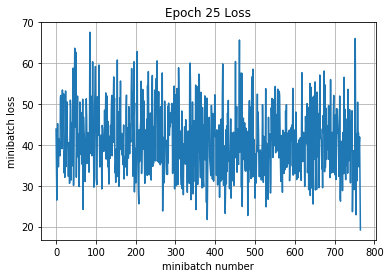

Iteration 19200: with minibatch training loss = 0.937 and accuracy of 0.7
Iteration 19300: with minibatch training loss = 0.6 and accuracy of 0.77
Iteration 19400: with minibatch training loss = 0.468 and accuracy of 0.86
Iteration 19500: with minibatch training loss = 0.795 and accuracy of 0.7
Iteration 19600: with minibatch training loss = 0.564 and accuracy of 0.77
Iteration 19700: with minibatch training loss = 0.701 and accuracy of 0.78
Iteration 19800: with minibatch training loss = 0.478 and accuracy of 0.81
Iteration 19900: with minibatch training loss = 0.434 and accuracy of 0.88
Epoch 26, Overall loss = 0.629 and accuracy of 0.785


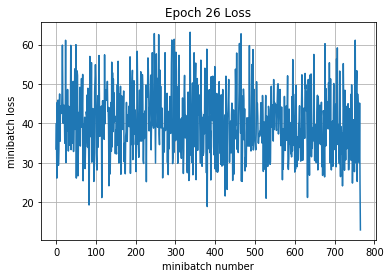

Iteration 20000: with minibatch training loss = 0.509 and accuracy of 0.88
Iteration 20100: with minibatch training loss = 0.539 and accuracy of 0.83
Iteration 20200: with minibatch training loss = 0.536 and accuracy of 0.83
Iteration 20300: with minibatch training loss = 0.627 and accuracy of 0.78
Iteration 20400: with minibatch training loss = 0.497 and accuracy of 0.78
Iteration 20500: with minibatch training loss = 0.449 and accuracy of 0.86
Iteration 20600: with minibatch training loss = 0.766 and accuracy of 0.75
Epoch 27, Overall loss = 0.612 and accuracy of 0.79


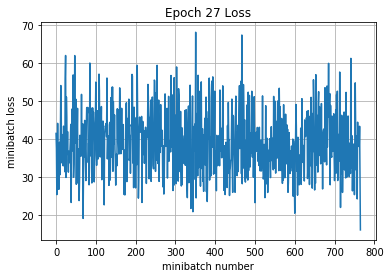

Iteration 20700: with minibatch training loss = 0.561 and accuracy of 0.81
Iteration 20800: with minibatch training loss = 0.634 and accuracy of 0.81
Iteration 20900: with minibatch training loss = 0.677 and accuracy of 0.77
Iteration 21000: with minibatch training loss = 0.681 and accuracy of 0.81
Iteration 21100: with minibatch training loss = 0.57 and accuracy of 0.81
Iteration 21200: with minibatch training loss = 0.525 and accuracy of 0.8
Iteration 21300: with minibatch training loss = 0.855 and accuracy of 0.67
Iteration 21400: with minibatch training loss = 0.408 and accuracy of 0.8
Epoch 28, Overall loss = 0.599 and accuracy of 0.794


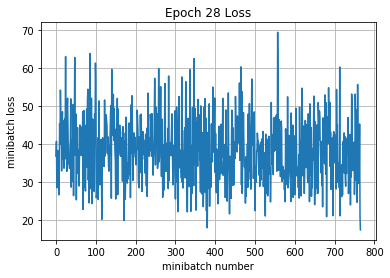

Iteration 21500: with minibatch training loss = 0.629 and accuracy of 0.8
Iteration 21600: with minibatch training loss = 0.519 and accuracy of 0.83
Iteration 21700: with minibatch training loss = 0.76 and accuracy of 0.8
Iteration 21800: with minibatch training loss = 0.492 and accuracy of 0.84
Iteration 21900: with minibatch training loss = 0.72 and accuracy of 0.77
Iteration 22000: with minibatch training loss = 0.684 and accuracy of 0.81
Iteration 22100: with minibatch training loss = 0.494 and accuracy of 0.83
Iteration 22200: with minibatch training loss = 0.757 and accuracy of 0.75
Epoch 29, Overall loss = 0.587 and accuracy of 0.801


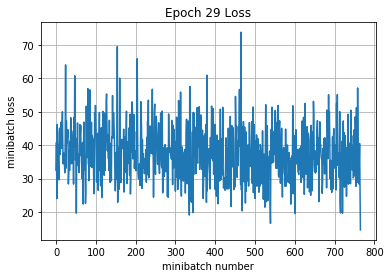

Iteration 22300: with minibatch training loss = 0.596 and accuracy of 0.83
Iteration 22400: with minibatch training loss = 0.823 and accuracy of 0.73
Iteration 22500: with minibatch training loss = 0.559 and accuracy of 0.8
Iteration 22600: with minibatch training loss = 0.648 and accuracy of 0.75
Iteration 22700: with minibatch training loss = 0.899 and accuracy of 0.7
Iteration 22800: with minibatch training loss = 0.609 and accuracy of 0.81
Iteration 22900: with minibatch training loss = 0.66 and accuracy of 0.77
Epoch 30, Overall loss = 0.572 and accuracy of 0.804


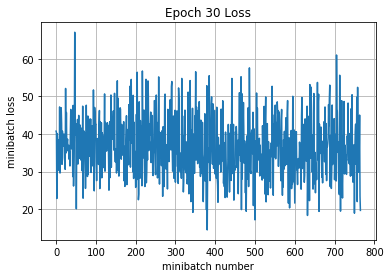

Iteration 23000: with minibatch training loss = 0.482 and accuracy of 0.86
Iteration 23100: with minibatch training loss = 0.451 and accuracy of 0.84
Iteration 23200: with minibatch training loss = 0.481 and accuracy of 0.83
Iteration 23300: with minibatch training loss = 0.576 and accuracy of 0.81
Iteration 23400: with minibatch training loss = 0.631 and accuracy of 0.81
Iteration 23500: with minibatch training loss = 0.478 and accuracy of 0.81
Iteration 23600: with minibatch training loss = 0.48 and accuracy of 0.84
Iteration 23700: with minibatch training loss = 0.272 and accuracy of 0.91
Epoch 31, Overall loss = 0.563 and accuracy of 0.806


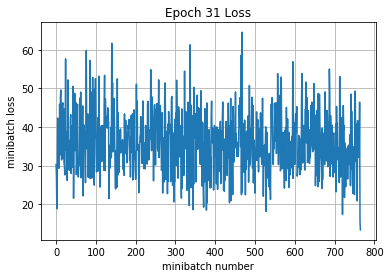

Iteration 23800: with minibatch training loss = 0.659 and accuracy of 0.77
Iteration 23900: with minibatch training loss = 0.963 and accuracy of 0.67
Iteration 24000: with minibatch training loss = 0.724 and accuracy of 0.75
Iteration 24100: with minibatch training loss = 0.811 and accuracy of 0.78
Iteration 24200: with minibatch training loss = 0.623 and accuracy of 0.78
Iteration 24300: with minibatch training loss = 0.767 and accuracy of 0.66
Iteration 24400: with minibatch training loss = 0.567 and accuracy of 0.77
Iteration 24500: with minibatch training loss = 0.488 and accuracy of 0.81
Epoch 32, Overall loss = 0.555 and accuracy of 0.81


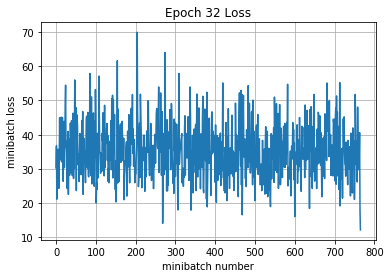

Iteration 24600: with minibatch training loss = 0.349 and accuracy of 0.88
Iteration 24700: with minibatch training loss = 0.413 and accuracy of 0.84
Iteration 24800: with minibatch training loss = 0.478 and accuracy of 0.86
Iteration 24900: with minibatch training loss = 0.412 and accuracy of 0.83
Iteration 25000: with minibatch training loss = 0.451 and accuracy of 0.8
Iteration 25100: with minibatch training loss = 0.416 and accuracy of 0.86
Iteration 25200: with minibatch training loss = 0.637 and accuracy of 0.81
Epoch 33, Overall loss = 0.539 and accuracy of 0.815


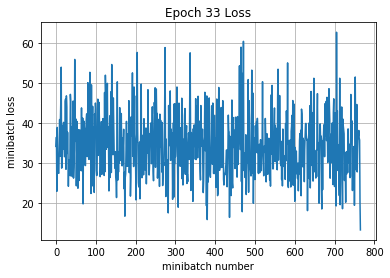

Iteration 25300: with minibatch training loss = 0.301 and accuracy of 0.88
Iteration 25400: with minibatch training loss = 0.693 and accuracy of 0.77
Iteration 25500: with minibatch training loss = 0.636 and accuracy of 0.81
Iteration 25600: with minibatch training loss = 0.533 and accuracy of 0.81
Iteration 25700: with minibatch training loss = 0.4 and accuracy of 0.86
Iteration 25800: with minibatch training loss = 0.334 and accuracy of 0.91
Iteration 25900: with minibatch training loss = 0.516 and accuracy of 0.83
Iteration 26000: with minibatch training loss = 0.584 and accuracy of 0.84
Epoch 34, Overall loss = 0.53 and accuracy of 0.817


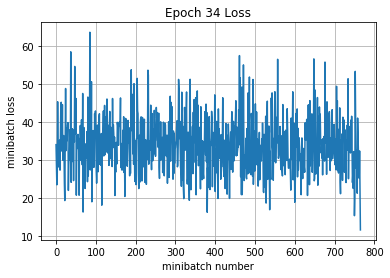

Iteration 26100: with minibatch training loss = 0.561 and accuracy of 0.78
Iteration 26200: with minibatch training loss = 0.645 and accuracy of 0.78
Iteration 26300: with minibatch training loss = 0.508 and accuracy of 0.86
Iteration 26400: with minibatch training loss = 0.543 and accuracy of 0.8
Iteration 26500: with minibatch training loss = 0.492 and accuracy of 0.8
Iteration 26600: with minibatch training loss = 0.432 and accuracy of 0.84
Iteration 26700: with minibatch training loss = 0.49 and accuracy of 0.81
Iteration 26800: with minibatch training loss = 0.458 and accuracy of 0.8
Epoch 35, Overall loss = 0.515 and accuracy of 0.822


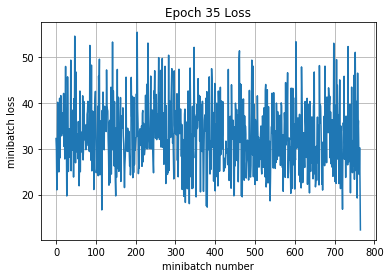

Iteration 26900: with minibatch training loss = 0.401 and accuracy of 0.83
Iteration 27000: with minibatch training loss = 0.52 and accuracy of 0.81
Iteration 27100: with minibatch training loss = 0.67 and accuracy of 0.73
Iteration 27200: with minibatch training loss = 0.608 and accuracy of 0.78
Iteration 27300: with minibatch training loss = 0.365 and accuracy of 0.84
Iteration 27400: with minibatch training loss = 0.395 and accuracy of 0.83
Iteration 27500: with minibatch training loss = 0.458 and accuracy of 0.84
Epoch 36, Overall loss = 0.51 and accuracy of 0.825


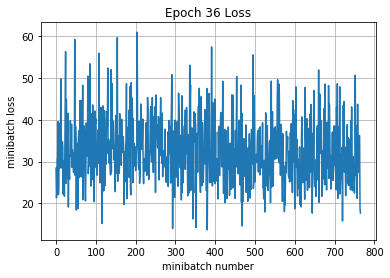

Iteration 27600: with minibatch training loss = 0.831 and accuracy of 0.77
Iteration 27700: with minibatch training loss = 0.688 and accuracy of 0.77
Iteration 27800: with minibatch training loss = 0.434 and accuracy of 0.81
Iteration 27900: with minibatch training loss = 0.634 and accuracy of 0.78
Iteration 28000: with minibatch training loss = 0.554 and accuracy of 0.78
Iteration 28100: with minibatch training loss = 0.466 and accuracy of 0.86
Iteration 28200: with minibatch training loss = 0.343 and accuracy of 0.84
Iteration 28300: with minibatch training loss = 0.731 and accuracy of 0.81
Epoch 37, Overall loss = 0.501 and accuracy of 0.829


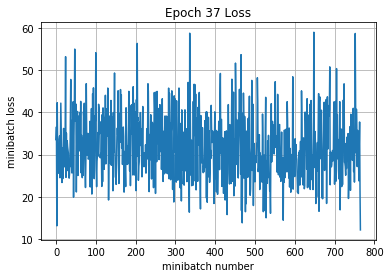

Iteration 28400: with minibatch training loss = 0.295 and accuracy of 0.91
Iteration 28500: with minibatch training loss = 0.321 and accuracy of 0.88
Iteration 28600: with minibatch training loss = 0.648 and accuracy of 0.78
Iteration 28700: with minibatch training loss = 0.464 and accuracy of 0.88
Iteration 28800: with minibatch training loss = 0.371 and accuracy of 0.94
Iteration 28900: with minibatch training loss = 0.663 and accuracy of 0.73
Iteration 29000: with minibatch training loss = 0.386 and accuracy of 0.86
Iteration 29100: with minibatch training loss = 0.586 and accuracy of 0.73
Epoch 38, Overall loss = 0.489 and accuracy of 0.83


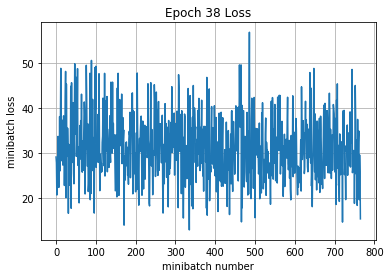

Iteration 29200: with minibatch training loss = 0.649 and accuracy of 0.8
Iteration 29300: with minibatch training loss = 0.673 and accuracy of 0.77
Iteration 29400: with minibatch training loss = 0.447 and accuracy of 0.83
Iteration 29500: with minibatch training loss = 0.552 and accuracy of 0.81
Iteration 29600: with minibatch training loss = 0.562 and accuracy of 0.81
Iteration 29700: with minibatch training loss = 0.498 and accuracy of 0.84
Iteration 29800: with minibatch training loss = 0.43 and accuracy of 0.88
Epoch 39, Overall loss = 0.476 and accuracy of 0.835


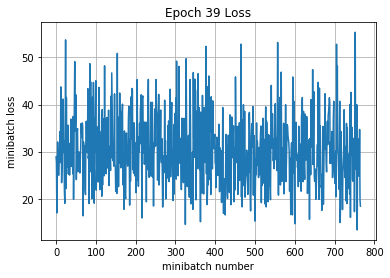

Iteration 29900: with minibatch training loss = 0.651 and accuracy of 0.83
Iteration 30000: with minibatch training loss = 0.563 and accuracy of 0.8
Iteration 30100: with minibatch training loss = 0.419 and accuracy of 0.86
Iteration 30200: with minibatch training loss = 0.406 and accuracy of 0.86
Iteration 30300: with minibatch training loss = 0.319 and accuracy of 0.91
Iteration 30400: with minibatch training loss = 0.338 and accuracy of 0.86
Iteration 30500: with minibatch training loss = 0.664 and accuracy of 0.8
Iteration 30600: with minibatch training loss = 0.441 and accuracy of 0.83
Epoch 40, Overall loss = 0.471 and accuracy of 0.838


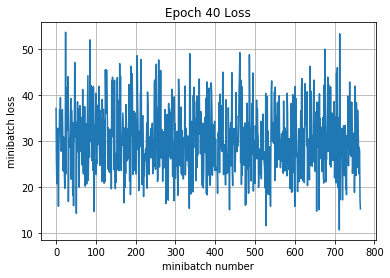

Validation
Epoch 1, Overall loss = 0.512 and accuracy of 0.849


(0.5119811711311341, 0.849)

In [13]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
def run_my_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, global_acc=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += float(np.sum(corr))
            global_acc = float(np.sum(corr))/actual_batch_size
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
#                 print (float(np.sum(corr))/actual_batch_size)
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,float(np.sum(corr))/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct


sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_my_model(sess,y_out,mean_loss,X_train,y_train,40,64,100,train_step, global_acc, True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [14]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.306 and accuracy of 0.894
Validation
Epoch 1, Overall loss = 0.512 and accuracy of 0.849


(0.511981166601181, 0.849)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

### Tell us here
I implement the simple version of resnet here

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [15]:
print('Test')

run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.551 and accuracy of 0.825


(0.5509691154479981, 0.8246)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

In [26]:
##implement a full version of resnet

In [16]:
import tensorflow as tf
import numpy as np
import time

In [17]:
def weights_init(shape):
   
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [18]:
def conv2d(scope, input_layer, output_dim, use_bias=False,
            filter_size=3, strides=[1, 1, 1, 1]):
    input_dim = input_layer.get_shape().as_list()[-1]

    with tf.variable_scope(scope):
        conv_filter = tf.get_variable(
            'conv_weight',
            shape = [filter_size, filter_size, input_dim, output_dim],
            dtype = tf.float32,
            initializer = tf.contrib.layers.variance_scaling_initializer(),
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.0002)
        )
        conv = tf.nn.conv2d(input_layer, conv_filter, strides, 'SAME')

        if use_bias:
            bias = tf.get_variable(
                'conv_bias',
                shape = [output_dim],
                dtype = tf.float32,
                initializer = tf.constant_initializer(0.0)
            )

            output_layer = tf.nn.bias_add(conv, bias)
            output_layer = tf.reshape(output_layer, conv.get_shape())
        else:
            output_layer = conv

        return output_layer

def batch_norm(scope, input_layer, is_training, reuse):

    output_layer = tf.contrib.layers.batch_norm(
        input_layer,
        decay = 0.9,
        scale = True,
        epsilon = 1e-5,
        is_training = is_training,
        reuse = reuse,
        scope = scope
    )

   
    return output_layer

def lrelu(input_layer, leak=0.2):
    output_layer = tf.nn.relu(input_layer)
    #output_layer = tf.maximum(input_layer, leak * input_layer)
    return output_layer

def fully_connected(scope, input_layer, output_dim):
    input_dim = input_layer.get_shape().as_list()[-1]
    
    with tf.variable_scope(scope):
        fc_weight = tf.get_variable(
            'fc_weight',
            shape = [input_dim, output_dim],
            dtype = tf.float32,
            initializer = tf.contrib.layers.variance_scaling_initializer(),
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.0002)            
        )

        fc_bias = tf.get_variable(
            'fc_bias',
            shape = [output_dim],
            dtype = tf.float32,
            initializer = tf.constant_initializer(0.0)
        )

        output_layer = tf.matmul(input_layer, fc_weight) + fc_bias

        return output_layer

def avg_pool(scope, input_layer, ksize=None, strides=[1, 2, 2, 1]):
    if ksize is None:
        ksize = strides

    with tf.variable_scope(scope):
        output_layer = tf.nn.avg_pool(input_layer, ksize, strides, 'VALID')
        return output_layer


In [19]:
def residual(scope, input_layer, is_training, reuse,
            increase_dim=False, first=False):
    input_dim = input_layer.get_shape().as_list()[-1]

    if increase_dim:
        output_dim = input_dim * 2
        strides = [1, 2, 2, 1]
    else:
        output_dim = input_dim
        strides = [1, 1, 1, 1]

    with tf.variable_scope(scope):
        if first:
            h0 = input_layer
        else:
            h0_bn = batch_norm('h0_bn', input_layer, is_training, reuse)
            h0 = lrelu(h0_bn)

        h1_conv = conv2d('h1_conv', h0, output_dim, strides=strides)
        h1_bn = batch_norm('h1_bn', h1_conv, is_training, reuse)
        h1 = lrelu(h1_bn)

        h2_conv = conv2d('h2_conv', h1, output_dim)
        if increase_dim:
            l = avg_pool('l_pool', input_layer)
            l = tf.pad(l, [[0, 0], [0, 0], 
                           [0, 0], [input_dim // 2, input_dim // 2]])
        else:
            l = input_layer
        h2 = tf.add(h2_conv, l)

        return h2


In [20]:
class ResNet(object):
    def __init__(self, num_units, image_shape,
                 train_batch_size, test_batch_size):

        self.num_units = num_units
        self.image_shape = image_shape
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size

        [height, width, channels] = image_shape
        train_batch_shape = [train_batch_size, height, width, channels]
        self.train_image_placeholder = tf.placeholder(
            tf.float32,
            shape = train_batch_shape,
            name = 'train_images'
        )
        self.train_label_placeholder = tf.placeholder(
            tf.int32,
            shape = [train_batch_size, ],
            name = 'train_labels'
        )


        test_batch_shape = [test_batch_size, height, width, channels]
        self.test_image_placeholder = tf.placeholder(
            tf.float32,
            shape = test_batch_shape,
            name = 'test_images'
        )
        self.test_label_placeholder = tf.placeholder(
            tf.int32,
            shape = [test_batch_size, ],
            name = 'test_labels'
        )

    def build_network(self, images, is_training, reuse):
        with tf.variable_scope('ResNet', reuse=reuse):
            init_dim = 16
            batch_size = images.get_shape().as_list()[0]

            r0_conv = conv2d('r0_conv', images, init_dim)
            r0_bn = batch_norm('r0_bn', r0_conv, is_training, reuse)
            r0 = lrelu(r0_bn)

            r1_res = residual('res1.0', r0, is_training, reuse, first=True)
            for k in range(1, self.num_units):
                r1_res = residual('res1.{}'.format(k), r1_res, is_training, reuse)

            r2_res = residual('res2.0', r1_res, is_training, reuse, increase_dim=True)
            for k in range(1, self.num_units):
                r2_res = residual('res2.{}'.format(k), r2_res, is_training, reuse)

            r3_res = residual('res3.0', r2_res, is_training, reuse, increase_dim=True)
            for k in range(1, self.num_units):
                r3_res = residual('res3.{}'.format(k), r3_res, is_training, reuse)

            r4_bn = batch_norm('r4_bn', r3_res, is_training, reuse)
            r4 = lrelu(r4_bn)

            axis = [1, 2]
            r5 = tf.reduce_mean(
                r4,
                axis = axis
            )

            fc = fully_connected('fc', tf.reshape(r5, [batch_size, -1]), 10)
            return tf.nn.softmax(fc), fc

    def build_train_op(self):
        train_step = tf.Variable(initial_value=0, trainable=False)
        #train_step_op = train_step.assign_add(1)
        self.train_step = train_step

        prob, logits = self.build_network(self.train_image_placeholder, True, False)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels = self.train_label_placeholder,
            logits = logits
        )
        
        decay = tf.train.exponential_decay(0.0002, train_step, 480000, 0.2, staircase=True)
        decay_loss = []
        for var in tf.trainable_variables():
            if var.op.name.find(r'weight') > 0:
                decay_loss.append(tf.nn.l2_loss(var))
        
        prediction = tf.equal(tf.cast(tf.argmax(prob, axis=1), tf.int32), self.train_label_placeholder)
        self.train_loss = tf.reduce_mean(loss) + tf.multiply(decay, tf.add_n(decay_loss))
        self.train_accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

        #lr_boundaries = [32000, 48000, 64000]
        #lr_values = [0.1, 0.01, 0.001, 0.0002]
        lr_boundaries = [400, 32000, 48000, 64000]
        lr_values = [0.01, 0.1, 0.01, 0.001, 0.0002]
        self.learning_rate = tf.train.piecewise_constant(train_step, lr_boundaries, lr_values)

        train_vars = [x for x in tf.trainable_variables() if 'ResNet' in x.name]
        optimizer = tf.train.MomentumOptimizer(self.learning_rate, 0.9)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(self.train_loss, global_step=train_step, var_list=train_vars)

        return train_op, self.train_loss, self.train_accuracy

    def build_test_op(self):
        prob, logits = self.build_network(self.test_image_placeholder, False, True)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels = self.test_label_placeholder,
            logits = logits
        )
        prediction = tf.equal(tf.cast(tf.argmax(prob, axis=1), tf.int32), self.test_label_placeholder)
        self.test_loss = tf.reduce_mean(loss)
        self.test_accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

        return self.test_loss, self.test_accuracy


In [21]:
import urllib
import os
import tarfile
import cv2

class Cifar10(object):
    def __init__(self, train_batch_size, test_batch_size):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        
        self.train_images=X_train
        self.train_labels =y_train
        self.test_images=X_val
        self.test_labels = y_val
        self.pp_mean = self.get_per_pixel_mean()
        self.shuffle_dataset()

        self.train_batch_count = self.train_images.shape[0] // self.train_batch_size
        self.test_batch_count = self.test_images.shape[0] // self.test_batch_size

    

    
    def get_per_pixel_mean(self):
        images = np.concatenate((self.train_images, self.test_images), axis=0)
        return np.mean(images, axis=0)

    def shuffle_dataset(self):
        self.shuffle = np.random.permutation(self.train_images.shape[0])

    def normalize(self, batch_images):
        return (batch_images- self.pp_mean) / 128.0

    def next_train_batch(self, idx):
        batch_images = self.train_images[self.shuffle[idx * self.train_batch_size : (idx + 1) * self.train_batch_size]]
        batch_labels = self.train_labels[self.shuffle[idx * self.train_batch_size : (idx + 1) * self.train_batch_size]]
        return self.normalize(batch_images), batch_labels

    def next_test_batch(self, idx):
        batch_images = self.test_images[idx * self.test_batch_size : (idx + 1) * self.test_batch_size]
        batch_labels = self.test_labels[idx * self.test_batch_size : (idx + 1) * self.test_batch_size]
        return self.normalize(batch_images), batch_labels

    def next_aug_train_batch(self, idx):
        batch_images = self.train_images[self.shuffle[idx * self.train_batch_size : (idx + 1) * self.train_batch_size]]
        batch_labels = self.train_labels[self.shuffle[idx * self.train_batch_size : (idx + 1) * self.train_batch_size]]

        # Padding
        pad_width = ((0, 0), (4, 4), (4, 4), (0, 0))
        padded_images = np.pad(batch_images, pad_width, mode='constant', constant_values=0)

        # Random crop and flip
        aug_batch_images = np.zeros_like(batch_images)
        for i in range(len(batch_images)):
            x = np.random.randint(0, high=8)
            y = np.random.randint(0, high=8)
            cropped_img = padded_images[i][x : x + 32, y : y + 32, :]
            is_flip = np.random.randint(0, high=9)
            if is_flip % 2 == 0:
                flipped_img = cv2.flip(cropped_img, flipCode=1)
            else:
                flipped_img = cropped_img
                
            np.copyto(aug_batch_images[i], flipped_img)
        
        return self.normalize(aug_batch_images), batch_labels


In [22]:
num_units = 5
exp_id = 5
gpu_number = 0
epoch = 50
image_shape = [32, 32, 3]
train_batch_size = 128
test_batch_size = 125
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_number)

log_file_path = os.path.join('cs231n/datasets', 'log_exp{}.txt'.format(exp_id))
log_file = open(log_file_path, 'w+')

In [23]:
def log(line):
    log_file.write(line)
    log_file.write('\n')
    log_file.flush()
    print (line)

In [24]:
def main(sess):
    dataset = Cifar10(train_batch_size, test_batch_size)
    model = ResNet(num_units, image_shape, train_batch_size, test_batch_size)
    train_op, train_loss, train_accuracy = model.build_train_op()
    test_loss, test_accuracy = model.build_test_op()
    
    #print("train_accuracy":train_accuracy)
    #print("val_accuracy":test_accuracy)
    
    global_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='')
    log('Global variables:')
    for i, var in enumerate(global_variables):
        log('{0} {1} {2}'.format(i, var.name, var.get_shape()))
    
    all_initializer_op = tf.global_variables_initializer()
    sess.run(all_initializer_op)
    
    for i in range(epoch):  
        total_loss = 0.0
        total_accuracy = 0.0
        dataset.shuffle_dataset()
        for j in range(dataset.train_batch_count):
            batch_images, batch_labels = dataset.next_aug_train_batch(j)
            
            sess.run(train_op,
                     feed_dict = {model.train_image_placeholder: batch_images, 
                                  model.train_label_placeholder: batch_labels})
            curr_loss, curr_accuracy = sess.run([train_loss,train_accuracy],
                                                feed_dict = {model.train_image_placeholder: batch_images, 
                                                             model.train_label_placeholder: batch_labels})
            #sess.run(train_step_op)
            total_loss += curr_loss
            total_accuracy += curr_accuracy
        
        total_loss /= dataset.train_batch_count
        total_accuracy /= dataset.train_batch_count
        log('Training epoch {0}, step {1}, learning rate {2}'.
            format(i, sess.run(model.train_step), sess.run(model.learning_rate)))
        print('train loss ',total_loss)
        print('train accuracy',total_accuracy)
            

        total_loss = 0.0
        total_accuracy = 0.0
        for k in range(dataset.test_batch_count):
            batch_images, batch_labels = dataset.next_test_batch(k)
                
            curr_loss, curr_accuracy = sess.run([test_loss, test_accuracy],
                                                feed_dict = {model.test_image_placeholder: batch_images,
                                                             model.test_label_placeholder: batch_labels})
            total_loss += curr_loss
            total_accuracy += curr_accuracy
            
        total_loss /= dataset.test_batch_count
        total_accuracy /= dataset.test_batch_count
        print('val loss',total_loss)
        print('val accuracy', total_accuracy)

In [25]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        main(sess)

log_file.close()

Global variables:
0 Variable:0 ()
1 ResNet/r0_conv/conv_weight:0 (3, 3, 3, 16)
2 ResNet/r0_bn/gamma:0 (16,)
3 ResNet/r0_bn/beta:0 (16,)
4 ResNet/r0_bn/moving_mean:0 (16,)
5 ResNet/r0_bn/moving_variance:0 (16,)
6 ResNet/res1.0/h1_conv/conv_weight:0 (3, 3, 16, 16)
7 ResNet/res1.0/h1_bn/gamma:0 (16,)
8 ResNet/res1.0/h1_bn/beta:0 (16,)
9 ResNet/res1.0/h1_bn/moving_mean:0 (16,)
10 ResNet/res1.0/h1_bn/moving_variance:0 (16,)
11 ResNet/res1.0/h2_conv/conv_weight:0 (3, 3, 16, 16)
12 ResNet/res1.1/h0_bn/gamma:0 (16,)
13 ResNet/res1.1/h0_bn/beta:0 (16,)
14 ResNet/res1.1/h0_bn/moving_mean:0 (16,)
15 ResNet/res1.1/h0_bn/moving_variance:0 (16,)
16 ResNet/res1.1/h1_conv/conv_weight:0 (3, 3, 16, 16)
17 ResNet/res1.1/h1_bn/gamma:0 (16,)
18 ResNet/res1.1/h1_bn/beta:0 (16,)
19 ResNet/res1.1/h1_bn/moving_mean:0 (16,)
20 ResNet/res1.1/h1_bn/moving_variance:0 (16,)
21 ResNet/res1.1/h2_conv/conv_weight:0 (3, 3, 16, 16)
22 ResNet/res1.2/h0_bn/gamma:0 (16,)
23 ResNet/res1.2/h0_bn/beta:0 (16,)
24 ResNet/res1.2